# MSE vs MAE: Understanding Outlier Sensitivity

## Introduction

When training machine learning models, we often choose between **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** as our loss functions. But how do they behave differently when our data contains outliers? This tutorial provides intuitive explanations and visual experiments to understand their fundamental differences.

## Key Takeaways

**MSE is outlier-sensitive** because it squares the residuals, heavily penalizing large errors. **MAE is outlier-robust** because it treats all errors with equal weight proportional to their magnitude.

---

## Experiment 1: How Loss Functions Penalize Errors

Let's first understand how each loss function treats prediction errors of different magnitudes.

### Mathematical Definitions

- **MSE Loss**: `L(r) = r²` where `r = prediction - truth`
- **MAE Loss**: `L(r) = |r|`

### Key Insight: Quadratic vs Linear Growth

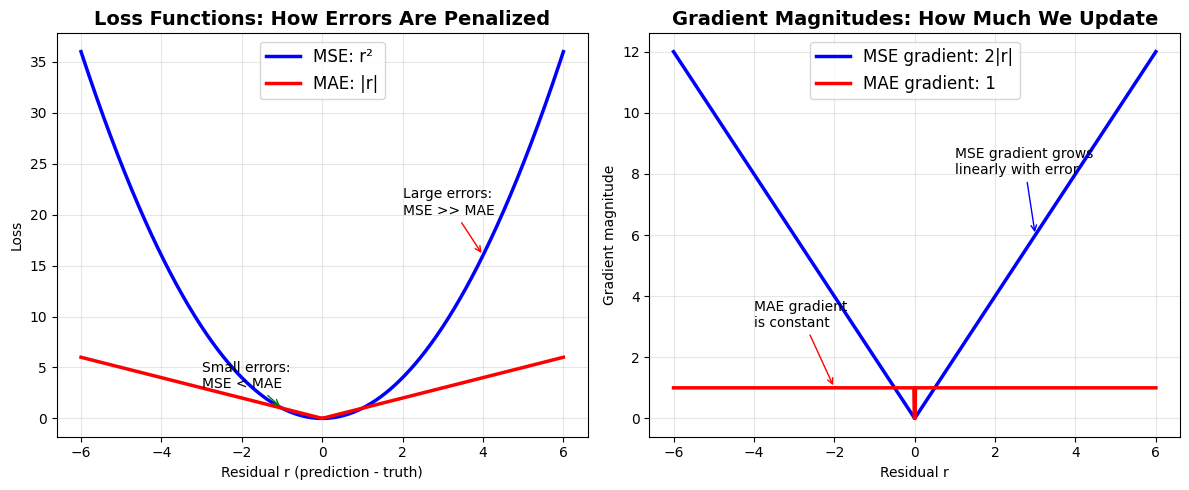

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Create residual values from -6 to +6
residuals = np.linspace(-6, 6, 1201)
mse_loss = residuals**2
mae_loss = np.abs(residuals)

# Create the comparison plot
plt.figure(figsize=(12, 5))

# Loss functions
plt.subplot(1, 2, 1)
plt.plot(residuals, mse_loss, 'b-', linewidth=2.5, label="MSE: r²")
plt.plot(residuals, mae_loss, 'r-', linewidth=2.5, label="MAE: |r|")
plt.title("Loss Functions: How Errors Are Penalized", fontsize=14, fontweight='bold')
plt.xlabel("Residual r (prediction - truth)")
plt.ylabel("Loss")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations for key points
plt.annotate('Small errors:\nMSE < MAE', xy=(-1, 1), xytext=(-3, 3),
            arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)
plt.annotate('Large errors:\nMSE >> MAE', xy=(4, 16), xytext=(2, 20),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

# Gradient comparison
gradients_mse = 2 * np.abs(residuals)
gradients_mae = np.ones_like(residuals)
gradients_mae[np.abs(residuals) < 0.01] = 0  # MAE gradient is 0 at r=0

plt.subplot(1, 2, 2)
plt.plot(residuals, gradients_mse, 'b-', linewidth=2.5, label="MSE gradient: 2|r|")
plt.plot(residuals, gradients_mae, 'r-', linewidth=2.5, label="MAE gradient: 1")
plt.title("Gradient Magnitudes: How Much We Update", fontsize=14, fontweight='bold')
plt.xlabel("Residual r")
plt.ylabel("Gradient magnitude")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotations
plt.annotate('MSE gradient grows\nlinearly with error', 
            xy=(3, 6), xytext=(1, 8),
            arrowprops=dict(arrowstyle='->', color='blue'), fontsize=10)
plt.annotate('MAE gradient\nis constant', 
            xy=(-2, 1), xytext=(-4, 3),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

plt.tight_layout()
plt.show()

### What This Means

- **For small errors** (|r| < 1): MSE actually penalizes less than MAE
- **For large errors** (|r| > 1): MSE penalizes disproportionately more than MAE
- **MSE gradients** scale with the error size → larger corrections for larger errors
- **MAE gradients** are constant → same correction regardless of error size

---

## Experiment 2: Real-World Impact - The Robust Location Problem

Imagine you're estimating the "typical" value of a dataset. This is exactly what happens when we minimize MSE (finds the mean) vs MAE (finds the median).

### The Setup: 49 Normal Points + 1 Extreme Outlier

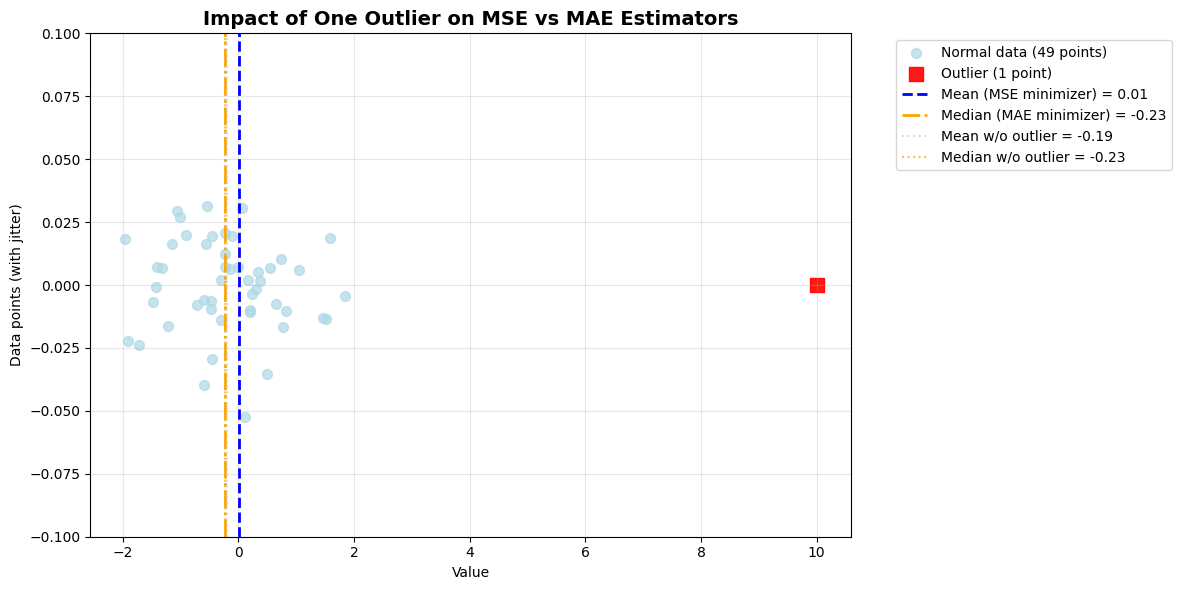

🔍 IMPACT ANALYSIS:
Mean shifted by: 0.204 units (-105.0% relative change)
Median shifted by: 0.004 units (-1.8% relative change)
MSE estimator moved 48.8x more than MAE estimator!


In [2]:
# Generate realistic data: mostly normal, one extreme outlier
inliers = np.random.normal(loc=0.0, scale=1.0, size=49)  # 49 typical data points
outlier = np.array([10.0])  # 1 extreme outlier
data = np.concatenate([inliers, outlier])

# Calculate optimal estimators
mean_estimate = data.mean()      # Minimizes MSE
median_estimate = np.median(data)  # Minimizes MAE

# For comparison: what would we get without the outlier?
mean_no_outlier = inliers.mean()
median_no_outlier = np.median(inliers)

# Visualize the impact
plt.figure(figsize=(12, 6))
y_jitter = np.random.normal(0, 0.02, size=len(data))  # Small vertical spread for visibility

plt.scatter(inliers, y_jitter[:49], alpha=0.7, s=50, color='lightblue', label='Normal data (49 points)')
plt.scatter([outlier[0]], [y_jitter[49]], alpha=0.9, s=100, color='red', label='Outlier (1 point)', marker='s')

# Show the estimators
plt.axvline(mean_estimate, color='blue', linestyle='--', linewidth=2, 
           label=f'Mean (MSE minimizer) = {mean_estimate:.2f}')
plt.axvline(median_estimate, color='orange', linestyle='-.', linewidth=2,
           label=f'Median (MAE minimizer) = {median_estimate:.2f}')

# Show what they would be without outlier
plt.axvline(mean_no_outlier, color='lightblue', linestyle=':', alpha=0.7,
           label=f'Mean w/o outlier = {mean_no_outlier:.2f}')
plt.axvline(median_no_outlier, color='orange', linestyle=':', alpha=0.7,
           label=f'Median w/o outlier = {median_no_outlier:.2f}')

plt.title("Impact of One Outlier on MSE vs MAE Estimators", fontsize=14, fontweight='bold')
plt.xlabel("Value")
plt.ylabel("Data points (with jitter)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 0.1)
plt.tight_layout()
plt.show()

# Quantify the impact
shift_mean = mean_estimate - mean_no_outlier
shift_median = median_estimate - median_no_outlier

print("🔍 IMPACT ANALYSIS:")
print(f"Mean shifted by: {shift_mean:.3f} units ({shift_mean/mean_no_outlier*100:.1f}% relative change)")
print(f"Median shifted by: {shift_median:.3f} units ({shift_median/median_no_outlier*100:.1f}% relative change)")
print(f"MSE estimator moved {abs(shift_mean/shift_median):.1f}x more than MAE estimator!")

### Key Insights from This Experiment

1. **The outlier "pulls" the mean significantly** toward itself
2. **The median barely budges** - it's determined by the middle value(s)
3. **One extreme point can drastically change MSE-based estimates**
4. **MAE-based estimates remain stable and representative of the majority**

---

## Experiment 3: The Loss Landscape - Where Optimization Leads Us

Let's visualize the actual loss functions that our optimization algorithms see.

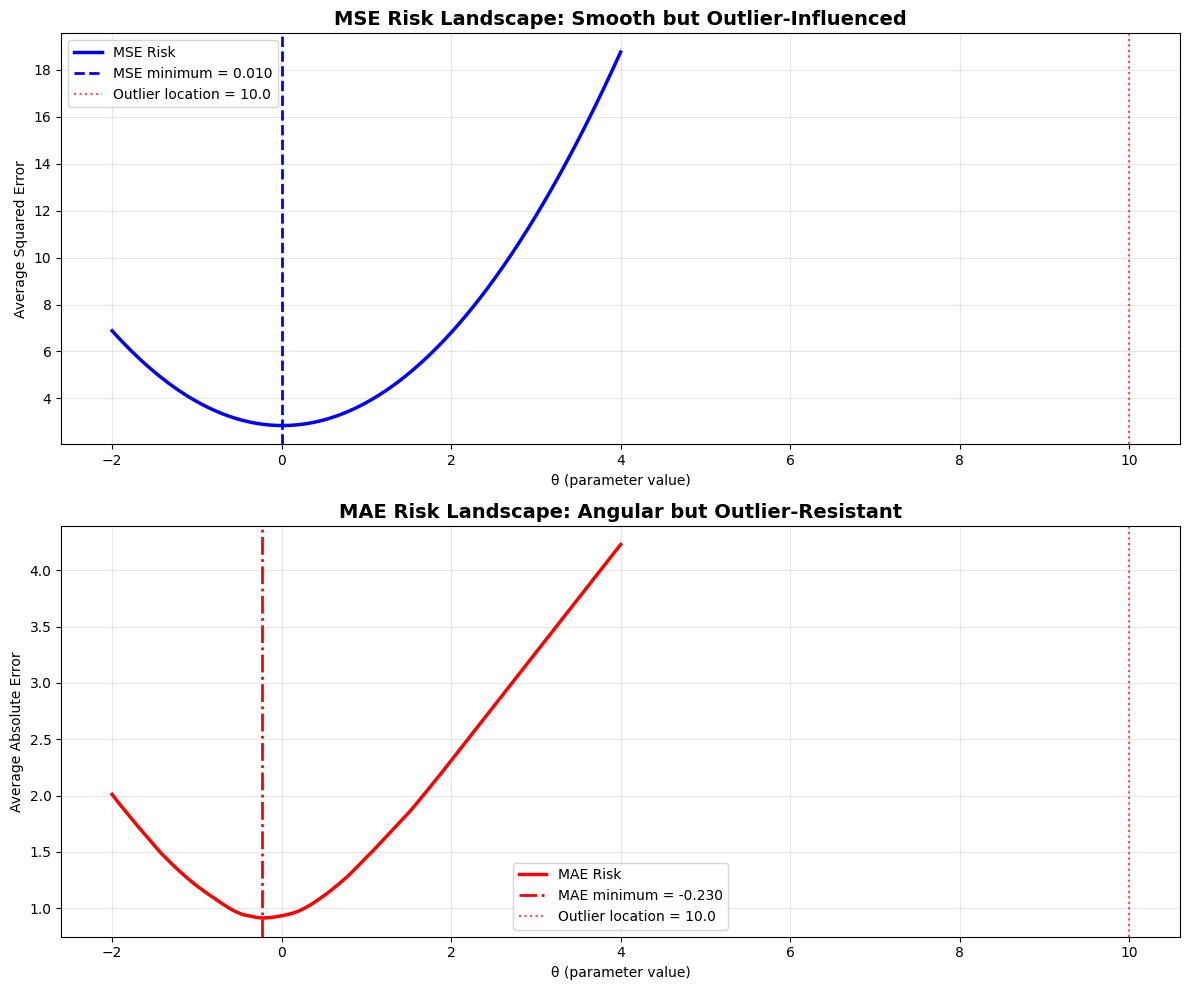

🎯 OPTIMIZATION RESULTS:
MSE leads us to θ = 0.010000 (sample mean)
MAE leads us to θ = -0.230000 (sample median)
True mean of inliers: -0.194095
True median of inliers: -0.234137


In [3]:
# Create a range of possible parameter values
theta_range = np.linspace(-2, 4, 1201)

# Calculate empirical risk for each theta
def calculate_mse_risk(theta_val):
    return np.mean((data - theta_val)**2)

def calculate_mae_risk(theta_val):
    return np.mean(np.abs(data - theta_val))

mse_risks = [calculate_mse_risk(t) for t in theta_range]
mae_risks = [calculate_mae_risk(t) for t in theta_range]

# Find the minimum points
theta_mse_min = theta_range[np.argmin(mse_risks)]
theta_mae_min = theta_range[np.argmin(mae_risks)]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# MSE Risk Curve
ax1.plot(theta_range, mse_risks, 'b-', linewidth=2.5, label='MSE Risk')
ax1.axvline(theta_mse_min, color='blue', linestyle='--', linewidth=2,
           label=f'MSE minimum = {theta_mse_min:.3f}')
ax1.axvline(outlier[0], color='red', linestyle=':', alpha=0.7,
           label=f'Outlier location = {outlier[0]:.1f}')
ax1.set_title("MSE Risk Landscape: Smooth but Outlier-Influenced", fontsize=14, fontweight='bold')
ax1.set_xlabel("θ (parameter value)")
ax1.set_ylabel("Average Squared Error")
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE Risk Curve  
ax2.plot(theta_range, mae_risks, 'r-', linewidth=2.5, label='MAE Risk')
ax2.axvline(theta_mae_min, color='red', linestyle='-.', linewidth=2,
           label=f'MAE minimum = {theta_mae_min:.3f}')
ax2.axvline(outlier[0], color='red', linestyle=':', alpha=0.7,
           label=f'Outlier location = {outlier[0]:.1f}')
ax2.set_title("MAE Risk Landscape: Angular but Outlier-Resistant", fontsize=14, fontweight='bold')
ax2.set_xlabel("θ (parameter value)")
ax2.set_ylabel("Average Absolute Error")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎯 OPTIMIZATION RESULTS:")
print(f"MSE leads us to θ = {theta_mse_min:.6f} (sample mean)")
print(f"MAE leads us to θ = {theta_mae_min:.6f} (sample median)")
print(f"True mean of inliers: {mean_no_outlier:.6f}")
print(f"True median of inliers: {median_no_outlier:.6f}")

### What the Loss Landscapes Tell Us

**MSE Curve Characteristics:**
- Smooth and differentiable everywhere
- Has a unique global minimum (the mean)
- The outlier "pulls" the minimum away from the bulk of the data

**MAE Curve Characteristics:**
- Piecewise linear with "kinks" at data points
- Can have flat regions (multiple optima)
- The minimum stays close to the center of the data distribution

---

## Practical Implications

### When to Use MSE
✅ **Use MSE when:**
- Your data has few outliers
- You want to penalize large errors heavily
- You need smooth gradients for optimization
- Small errors are more acceptable than large errors

### When to Use MAE
✅ **Use MAE when:**
- Your data contains outliers
- You want robust predictions
- All error magnitudes should be treated equally
- You can handle non-smooth optimization

### Real-World Examples

**MSE is better for:**
- Image reconstruction (pixel-perfect matters)
- Financial forecasting (large errors are catastrophic)
- Scientific measurements (precision is key)

**MAE is better for:**
- Robust statistics (median income vs mean income)
- Computer vision with noisy data
- Time series with occasional anomalies
- Any domain where outliers shouldn't dominate

---

## Summary

The fundamental difference between MSE and MAE lies in how they treat large errors:

1. **MSE squares the residuals** → outliers have quadratically larger influence
2. **MAE uses absolute values** → outliers have proportionally larger influence
3. **MSE minimization finds the mean** → pulled by extreme values
4. **MAE minimization finds the median** → robust to extreme values

Understanding this difference helps you choose the right loss function for your specific problem and data characteristics.